In [1]:
''' plot spatial maps for HRMIP data and FCN outputs '''
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
import h5py
from collections import OrderedDict

In [2]:
yr_range = 10     # how many years to average across
start = 2015      # starting year for analysis
end = 2045        # ending year for analysis
dt = 33           # 36*6/24 = 9 days between ICs over any year
n_samples = 1460  # n samples every year
ics = np.arange(0, n_samples, dt)   # subselect these indices over any year

# some hrmip dataset details
base_dataset_pl_vars = OrderedDict(zip(['q', 't', 'u', 'v', 'z'], range(5)))
base_dataset_sl_vars = OrderedDict(zip(['msl', 't2m', 'u10', 'v10'], range(4)))
base_dataset_pressure_levels = OrderedDict(zip([925, 800, 700, 600, 500, 250], range(6)))

# paths to all the data and predictions

# EC3P
path_future = "/pscratch/sd/p/pharring/cmip_data/EC-Earth3P-HR/highresSST-future/r2i1p1f1"
path_present = "/pscratch/sd/p/pharring/cmip_data/EC-Earth3P-HR/highresSST-present/r2i1p1f1"

# FCN outputs
path_fcn = "/pscratch/sd/s/shas1693/results/climate/afno_backbone_ec3p_r2i1p1f1_p4_e768_depth12_lr1em3_finetune/"

In [3]:
# which field to look at
# pressure field
# fld = "q"
# level = 925
# pl_idx = base_dataset_pl_vars[fld]
# lvl = base_dataset_pressure_levels[level]
# print(pl_idx, lvl)
# flattened_idx = pl_idx*6 + lvl

# surface field
sl_idx = base_dataset_sl_vars['t2m']
print(sl_idx)           
flattened_idx = 30 + sl_idx

print("index in input array = {}".format(flattened_idx))

1
index in input array = 31


In [4]:
# prefilter to some spatial region
# tropics is 20S to 20N
prefilter = False
if prefilter:
    lat_n = 20
    lat_s = 20
    n = 512
    n_pixel_per_deg = n/180
    low = int(n//2 - n_pixel_per_deg * lat_s)
    high = int(n//2 + n_pixel_per_deg * lat_n)
else:
    low = 0
    high = 511
print(low, high)
index_set = list(range(low,high))

0 511


In [5]:
# daily climatology for var in analysis
daily_climatology_path = os.path.join(path_present, "stats/time_means_daily.h5")
with h5py.File(daily_climatology_path, "r") as f:
    daily_climatology = f['time_means_daily'][:,flattened_idx,low:high]
print(daily_climatology.shape)


# global means and stds to un-normalize FCN predictions
global_means_path = os.path.join(path_present, "stats/global_means.npy")
global_stds_path = os.path.join(path_present, "stats/global_stds.npy")
gmean = np.load(global_means_path)[0,flattened_idx,0,0]
gstd = np.load(global_stds_path)[0,flattened_idx,0,0]
print(gmean.shape, gstd.shape)

(1460, 511, 1024)
() ()


In [6]:
# get array shapes
with h5py.File(os.path.join(*[path_future, "2015.h5"]), "r") as f:
    var = f['sl'][:,sl_idx,low:high]
sh = var.shape
print("variable shape is {}".format(sh))

variable shape is (1460, 511, 1024)


In [7]:
# spatial averages

gt_average = []
temp = np.zeros((sh[1], sh[2]))

# ts = ics + 4
# print(ts)

for count, y in enumerate(list(range(start, end+1))):
    future_str     = "{}.h5".format(y)
    print("running {}".format(future_str))
    
    with h5py.File(os.path.join(*[path_future, future_str]), "r") as f:
        # var = f['pl'][0:n_samples,pl_idx,lvl,low:high]  # pressure level var
        var = f['sl'][:,sl_idx,low:high]   # surface level var
        print("averaging over shape {}".format(var.shape))
        var = np.mean(var, axis=0) # average over the year
        temp += var                # running average over yr_range years
             
    if (count+1)%yr_range == 0 and count != 0:
        temp /= yr_range
        gt_average.append(temp)
        temp = np.zeros((sh[1], sh[2]))

running 2015.h5
averaging over shape (1460, 511, 1024)
running 2016.h5
averaging over shape (1464, 511, 1024)
running 2017.h5
averaging over shape (1460, 511, 1024)
running 2018.h5
averaging over shape (1460, 511, 1024)
running 2019.h5
averaging over shape (1460, 511, 1024)
running 2020.h5
averaging over shape (1464, 511, 1024)
running 2021.h5
averaging over shape (1460, 511, 1024)
running 2022.h5
averaging over shape (1460, 511, 1024)
running 2023.h5
averaging over shape (1460, 511, 1024)
running 2024.h5
averaging over shape (1464, 511, 1024)
running 2025.h5
averaging over shape (1460, 511, 1024)
running 2026.h5
averaging over shape (1460, 511, 1024)
running 2027.h5
averaging over shape (1460, 511, 1024)
running 2028.h5
averaging over shape (1464, 511, 1024)
running 2029.h5
averaging over shape (1460, 511, 1024)
running 2030.h5
averaging over shape (1460, 511, 1024)
running 2031.h5
averaging over shape (1460, 511, 1024)
running 2032.h5
averaging over shape (1464, 511, 1024)
running 20

In [19]:
fcn_average = []
temp = np.zeros((sh[1], sh[2]))

# FCN predictions (ics, saved_time_points, ch, nx, ny):  saved_time_points = [4,12,20,28]
t_idx = 2 # which saved time point index

for count, y in enumerate(list(range(start, end+1))):
    future_str_fcn = "year{}/autoregressive_predictions_z500_save_33steps.h5".format(y)
    print("running {}".format(future_str_fcn))
    
    with h5py.File(os.path.join(*[path_fcn, future_str_fcn]), "r") as f:
        var = (f['pred'][:,t_idx,flattened_idx,low:high]) * gstd + gmean
        var = np.mean(var, axis=0) # average over the year
        temp += var                # running average over yr_range years
             
    if (count+1)%yr_range == 0 and count != 0:
        temp /= yr_range
        fcn_average.append(temp)
        temp = np.zeros((sh[1], sh[2]))

running year2015/autoregressive_predictions_z500_save_33steps.h5
running year2016/autoregressive_predictions_z500_save_33steps.h5
running year2017/autoregressive_predictions_z500_save_33steps.h5
running year2018/autoregressive_predictions_z500_save_33steps.h5
running year2019/autoregressive_predictions_z500_save_33steps.h5
running year2020/autoregressive_predictions_z500_save_33steps.h5
running year2021/autoregressive_predictions_z500_save_33steps.h5
running year2022/autoregressive_predictions_z500_save_33steps.h5
running year2023/autoregressive_predictions_z500_save_33steps.h5
running year2024/autoregressive_predictions_z500_save_33steps.h5
running year2025/autoregressive_predictions_z500_save_33steps.h5
running year2026/autoregressive_predictions_z500_save_33steps.h5
running year2027/autoregressive_predictions_z500_save_33steps.h5
running year2028/autoregressive_predictions_z500_save_33steps.h5
running year2029/autoregressive_predictions_z500_save_33steps.h5
running year2030/autoregr

In [20]:
def plot(ax, z, **kwargs):
    im = ax.imshow(z, **kwargs)
    plt.colorbar(im, ax=ax, orientation="horizontal")


def maps(average, fcn_average, kw=dict(vmin=200, vmax=320, cmap="viridis"), diff_scale=5):
    fig = plt.figure(figsize=(11, 9))
    fig.suptitle("T2M (K) for three decades")

    ax = fig.add_subplot(331)
    plot(ax, average[0], **kw)
    ax.set_title("2015-2025 (ground truth)")

    ax = fig.add_subplot(332)
    plot(ax, average[1], **kw)
    ax.set_title("2025-2035 (ground truth)")

    ax = fig.add_subplot(333)
    plot(ax, average[2], **kw)
    # plot(ax, average[2]-average[0], vmin=-diff_scale, vmax=diff_scale, cmap="RdBu_r")
    ax.set_title("2035-2045 (ground truth)")
    
    ax = fig.add_subplot(334)
    plot(ax, fcn_average[0], **kw)
    ax.set_title("2015-2025 (FCN)")

    ax = fig.add_subplot(335)
    plot(ax, fcn_average[1], **kw)
    ax.set_title("2025-2035 (FCN)")

    ax = fig.add_subplot(336)
    plot(ax, fcn_average[2], **kw)
    ax.set_title("2035-2045 (FCN)")
    
    ax = fig.add_subplot(337)
    plot(ax, -average[0]+fcn_average[0], vmin=-diff_scale, vmax=diff_scale, cmap="RdBu_r")
    ax.set_title("2015-2025 (FCN - HRMIP)")

    ax = fig.add_subplot(338)
    plot(ax, -average[1]+fcn_average[1], vmin=-diff_scale, vmax=diff_scale, cmap="RdBu_r")
    ax.set_title("2025-2035 (FCN - HRMIP)")

    ax = fig.add_subplot(339)
    plot(ax, -average[2]+fcn_average[2], vmin=-diff_scale, vmax=diff_scale, cmap="RdBu_r")
    ax.set_title("2035-2045 (FCN - HRMIP)")

3 (511, 1024) (511, 1024)


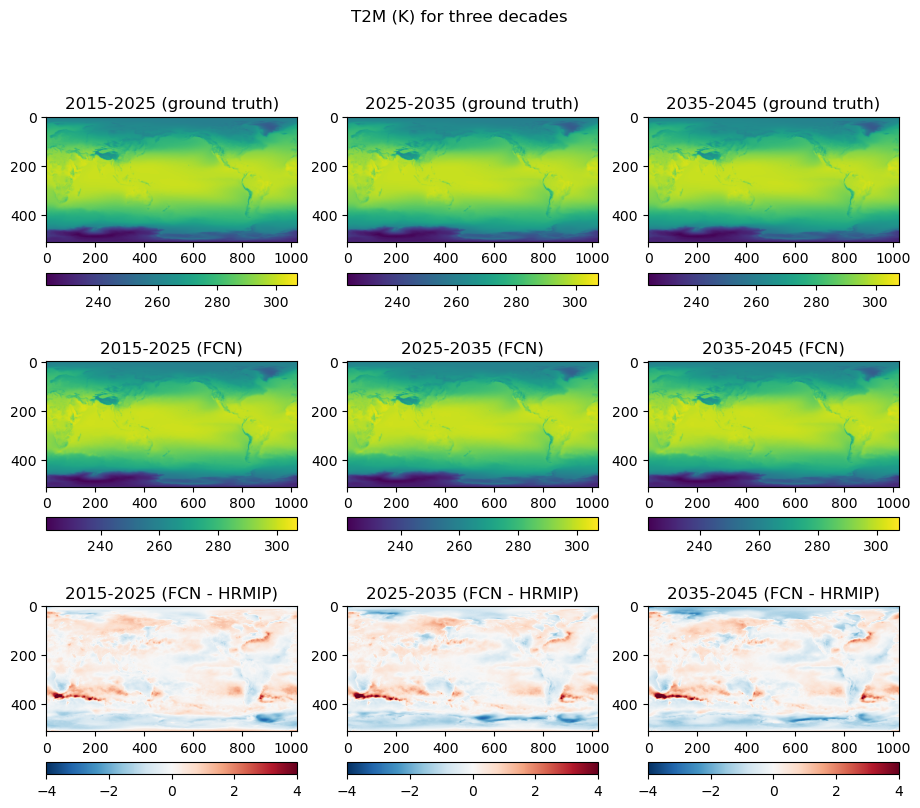

In [21]:
print(len(gt_average), gt_average[0].shape, (fcn_average[0].shape))
var_min = np.min(gt_average[0])
var_max = np.min(gt_average[1])
maps(gt_average, fcn_average, kw=dict(cmap="viridis"), diff_scale=4)